In [35]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [36]:
FIGSIZE = (20, 6)

location = "A101"
idx = "datetime"
target = "global-radiation"
by_day_rolling = pd.read_csv(f"treated-data/by_day_rolling_{location}.csv")
by_day_rolling.tail()

,datetime,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
7695,2024-07-27,476.621429,0.088393,68.361607,29.784226,28.704464,1.377827,3.832589
7696,2024-07-28,484.957440,0.088393,68.081845,29.802083,28.742708,1.412351,3.895833
7697,2024-07-29,489.300893,0.088393,67.665179,29.846577,28.797619,1.440327,3.952083
7698,2024-07-30,492.486161,0.088393,67.212798,29.903869,28.858482,1.439732,3.946131
7699,2024-07-31,500.735261,0.088095,66.473150,30.018705,28.974224,1.456166,3.951100


In [37]:
by_day_rolling[idx] = by_day_rolling[idx].apply(
    lambda d: pd.to_datetime(d, format="%Y-%m-%d")
)
by_day_rolling = by_day_rolling.set_index(idx)
by_day_rolling.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2024-07-27,476.621429,0.088393,68.361607,29.784226,28.704464,1.377827,3.832589
2024-07-28,484.957440,0.088393,68.081845,29.802083,28.742708,1.412351,3.895833
2024-07-29,489.300893,0.088393,67.665179,29.846577,28.797619,1.440327,3.952083
2024-07-30,492.486161,0.088393,67.212798,29.903869,28.858482,1.439732,3.946131
2024-07-31,500.735261,0.088095,66.473150,30.018705,28.974224,1.456166,3.951100


'train len = 6910'

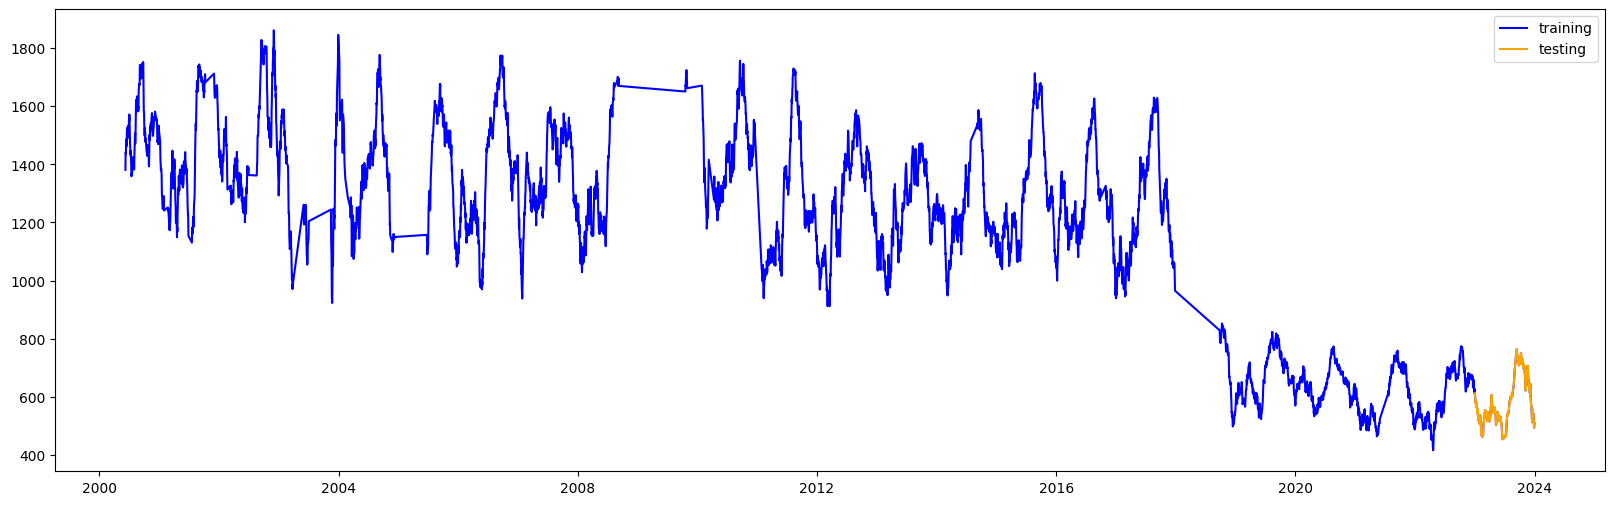

In [38]:
from src.train_test_data import split_datasets, training_threshold, testing_treshold


date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)

train_rolling, test_rolling = split_datasets(
    by_day_rolling, date_threshold, date_upper_threshold
)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

f"train len = {train_rolling[target].size}"

In [39]:
xgb_df = by_day_rolling.copy()
xgb_df["lag1"] = (xgb_df.index - pd.DateOffset(years=1)).map(
    train_rolling[target].to_dict()
)
xgb_df.index - pd.DateOffset(years=1)
xgb_df["lag2"] = (xgb_df.index - pd.DateOffset(years=2)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag3"] = (xgb_df.index - pd.DateOffset(years=3)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag4"] = (xgb_df.index - pd.DateOffset(years=4)).map(
    train_rolling[target].to_dict()
)
# xgb_df["lag_history"] = xgb_df.index.day_of_year.map(all_years[target].to_dict())

xgb_df["date"] = xgb_df.index

xgb_df["doy"] = xgb_df["date"].apply(lambda d: d.day_of_year)
xgb_df["woy"] = xgb_df["date"].apply(lambda d: d.date().isocalendar()[1])
xgb_df["month"] = xgb_df["date"].apply(lambda d: d.month)

xgb_df.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,lag1,lag2,lag3,lag4,date,doy,woy,month
datetime,,,,,,,,,,,,,,,
2024-07-27,476.621429,0.088393,68.361607,29.784226,28.704464,1.377827,3.832589,548.481696,696.444424,636.287500,693.044156,2024-07-27,209,30,7
2024-07-28,484.957440,0.088393,68.081845,29.802083,28.742708,1.412351,3.895833,550.187798,697.403490,634.012649,691.932305,2024-07-28,210,30,7
2024-07-29,489.300893,0.088393,67.665179,29.846577,28.797619,1.440327,3.952083,559.396875,679.044813,644.661012,701.868182,2024-07-29,211,31,7
2024-07-30,492.486161,0.088393,67.212798,29.903869,28.858482,1.439732,3.946131,566.470833,666.894435,641.420536,707.759416,2024-07-30,212,31,7
2024-07-31,500.735261,0.088095,66.473150,30.018705,28.974224,1.456166,3.951100,577.637202,662.913715,658.791220,721.857955,2024-07-31,213,31,7


In [40]:
feats = ["doy", "woy", *[c for c in xgb_df.columns if "lag" in c]]
# for c in xgb_df.columns:
#     if c == target:
#         continue
#     if abs(xgb_df.corr()[target][c]) >= 0.5:
#         feats.append(c)
print(feats)

xgb_train = xgb_df.loc[training_threshold(xgb_df.index, date_threshold)]
xgb_test = xgb_df.loc[
    testing_treshold(xgb_df.index, date_threshold, date_upper_threshold)
]


def split_x_y_xgb(df, feats, target):
    return df.loc[df[target].notna(), feats], df.loc[df[target].notna(), target]


X_train, y_train = split_x_y_xgb(xgb_train, feats, target)
X_test, y_test = split_x_y_xgb(xgb_test, feats, target)

len(X_test), len(X_train)

['doy', 'woy', 'lag1', 'lag2', 'lag3', 'lag4']


(365, 7096)

In [41]:
reg = xgb.XGBRegressor(
    base_score=1.0,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=500,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.1,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:1102.58634	validation_1-rmse:524.87756
[100]	validation_0-rmse:132.16728	validation_1-rmse:95.64147
[200]	validation_0-rmse:115.02442	validation_1-rmse:108.18470
[300]	validation_0-rmse:103.83756	validation_1-rmse:115.45632
[400]	validation_0-rmse:95.85743	validation_1-rmse:118.92873
[500]	validation_0-rmse:89.09200	validation_1-rmse:122.62397
[526]	validation_0-rmse:87.82129	validation_1-rmse:121.46050


XGBRegressor(base_score=1.0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

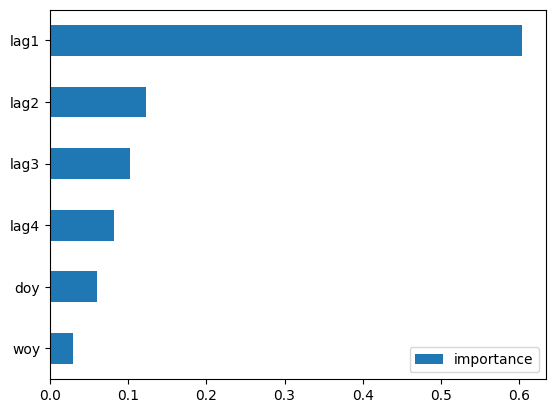

In [42]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
).sort_values("importance")

feature_importance.plot(kind="barh")

In [43]:
xgb_prediction = reg.predict(X_test)

prediction = pd.DataFrame(
    data=xgb_prediction, index=X_test.index, columns=["prediction"]
)
prediction = prediction.merge(
    test_rolling.loc[:, target],
    left_index=True,
    right_index=True,
)

'xgb error = 0.0981%'

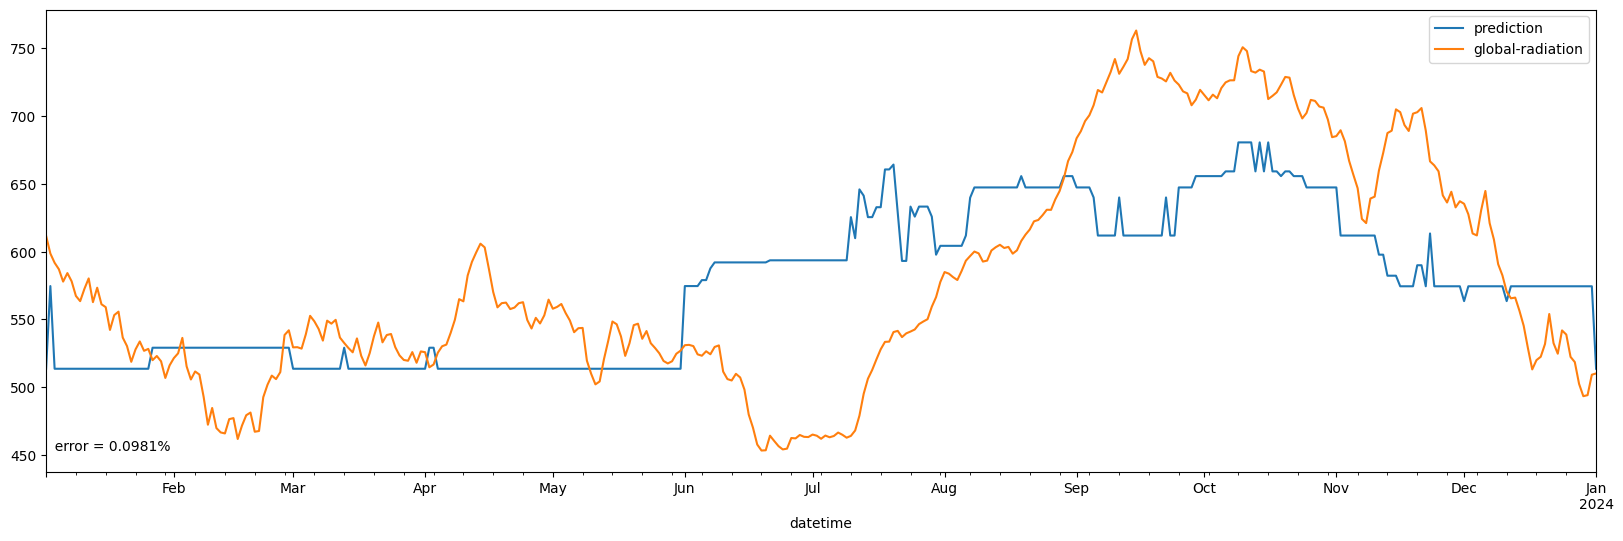

In [53]:
xgb_error = mape(prediction[target], prediction.prediction)
ax = prediction.plot(figsize=FIGSIZE)
ax.text(prediction.index.min(), prediction.min(None), f"  error = {xgb_error:.4f}%")

f"xgb error = {xgb_error:.4f}%"